# Project 4: Concrete Compressive Strength Prediction

The objective in this case study is to produce a predictive model that can accurately predict the compressive strength of concrete. Here compressive strength, measured in megapascal (MPa), is a continuous target. Thus we will be developing a regression based model. 

The following steps will need to be accomplished in order to deliver this objective:
1. [Import the dataset and libraries](#1)
2. [Exploratory Data Analysis](#2)
3. [Data Preprocessing and Feature Extraction](#3)
4. [Baseline Model Building](#4)
5. [Hyper-Parameter Tuning](#5)
6. [Model Performance on Unseen Data](#6)
7. [Optimizing for Compressive Strength using Particle Swarm Optimization](#7)

<a id="1"></a>
### Step 1: Import the dataset and libraries

In this section we will first load all of the nessecary libraries. Next we will load the dataset noting how many records there are, identifying the data types present, and checking for missing values.

In [1]:
import pandas as pd
import numpy as np 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# configure visualization defaults
plt.style.use('fivethirtyeight')
%matplotlib inline

# ignore warnings
import warnings; warnings.simplefilter('ignore')

# models used in this analysis
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression

# model helpers
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

# scoring metrics
from sklearn.metrics import mean_squared_error, r2_score

# Particle Swarm Optimization
import pyswarms as ps

In [2]:
# load the data as pandas dataframe
data = pd.read_csv("concrete.csv")

In [3]:
# verify that the data loaded correctly
data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [4]:
# get the number of rows and columns of the data
print("There are {} rows and {} columns in the dataset.".format(data.shape[0],data.shape[1]))

There are 1030 rows and 9 columns in the dataset.


***Description of Features***

| Name                          | Data Type    | Measurement        | Description    |
|-------------------------------|--------------|--------------------|----------------|
|                        Cement | quantitative | kg in a m3 mixture | Input Variable |
|            Blast Furnace Slag | quantitative | kg in a m3 mixture | Input Variable |
|                       Fly Ash | quantitative | kg in a m3 mixture | Input Variable |
|                         Water | quantitative | kg in a m3 mixture | Input Variable |
|              Superplasticizer | quantitative | kg in a m3 mixture | Input Variable |
|              Coarse Aggregate | quantitative | kg in a m3 mixture | Input Variable |
|                Fine Aggregate | quantitative | kg in a m3 mixture | Input Variable |
|                           Age | quantitative |        Day (1~365) | Input Variable |
| Concrete compressive strength | quantitative |                MPa | Target         |


In [5]:
# Using data.info(), we can inspect the various data types in our dataset and also check for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


All of the input features are numerical as is the target variable. There are no missing values in the dataset. Next we check for **duplicate** rows. 

In [6]:
# checking for duplicates
duplicates = data.duplicated()
data[duplicates].shape[0]

25

There are 25 duplicate records in the data. We should drop these duplicate records because having duplicate instances in both the training and test sets can result in overly optimistic model performance.

In [7]:
# dropping duplicate records
data.drop_duplicates(inplace=True)

print("Remaining rows after dropping duplicates: {}".format(data.shape[0]))

Remaining rows after dropping duplicates: 1005


Before we dive into EDA portion of the case study, let's first assemble a data quality report.

In [8]:
def data_report(dataframe):
    
    # create numerical data report using built in describe() method
    data_report = dataframe.describe().T
    
    # add a percent missing column
    data_report['% missing'] = dataframe.apply(lambda x: x.isna().mean())
    
    # add a cardinality column
    data_report['cardinality'] = dataframe.apply(lambda x: x.nunique())
    
    # add a skew column
    data_report['skew'] = dataframe.apply(lambda x: x.skew())
    
    # rearrange the columns 
    cols = ['count','% missing','cardinality','mean','std','min','25%','50%','75%','max','skew']
    data_report = data_report[cols]
    
    return data_report

In [9]:
data_report(data)

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
cement,1005.0,0.0,278,278.631343,104.344261,102.00,190.70,265.0,349.00,540.0,0.564959
slag,1005.0,0.0,185,72.043483,86.170807,0.00,0.00,20.0,142.50,359.4,0.855225
ash,1005.0,0.0,156,55.536318,64.207969,0.00,0.00,0.0,118.30,200.1,0.497231
water,1005.0,0.0,195,182.075323,21.339334,121.80,166.60,185.7,192.90,247.0,0.034433
superplastic,1005.0,0.0,111,6.033234,5.919967,0.00,0.00,6.1,10.00,32.2,0.980604
coarseagg,1005.0,0.0,284,974.376816,77.579667,801.00,932.00,968.0,1031.00,1145.0,-0.065256
fineagg,1005.0,0.0,302,772.688259,80.340435,594.00,724.30,780.0,822.20,992.6,-0.252353
age,1005.0,0.0,14,45.856716,63.734692,1.00,7.00,28.0,56.00,365.0,3.253974
strength,1005.0,0.0,845,35.250378,16.284815,2.33,23.52,33.8,44.87,82.6,0.395696


The data quality reports provide a high level overview of the data we will be using to train the models. The report draws our attention to any immediate data quality issues i.e. missing values, irregular cardinality, large standard deviations, extreme skewness, etc. In the above report nothing suspicious catches our eye. Indeed, most of the features are well behaved save perhaps "age" which has some skewness to it and "cement" which has a large range of values implicated by its rather large standard deviation compared to its mean. 

<a id="2"></a>
### Step 2: Exploratory Data Analysis
#### 2.1 Univariate Analysis

<b style="color:#2E86C1;font-size:15px;">Cement and Slag</b>

In [10]:
data_report(data).loc[['cement','slag']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
cement,1005.0,0.0,278,278.631343,104.344261,102.0,190.7,265.0,349.0,540.0,0.564959
slag,1005.0,0.0,185,72.043483,86.170807,0.0,0.0,20.0,142.5,359.4,0.855225


2020-10-30 13:50:12,825 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


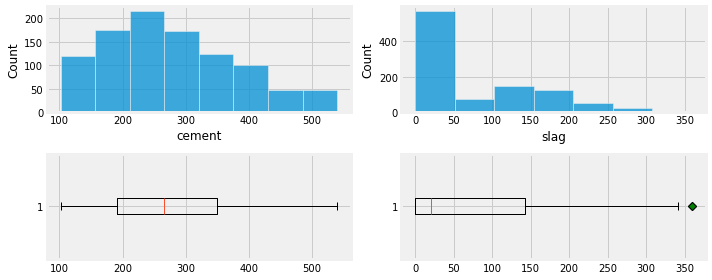

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

sns.histplot(data=data, x='cement', bins=8, ax=axes[0,0]);
sns.histplot(data=data, x='slag', bins=7, ax=axes[0,1]);
axes[1,0].boxplot(data['cement'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['slag'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

- Cement exhibits a slight right skewness with a large spread in values
- A large portion of the records, at least 25%, have 0 slag in the concrete mixture. 

In [12]:
# percentage of mixtures that have 0 slag
missing_slag_perc = round(data[data.slag == 0].shape[0]/data.shape[0]*100)

print("{}% of the concrete mixtures had no slag added.".format(missing_slag_perc))


47% of the concrete mixtures had no slag added.


<b style="color:#2E86C1;font-size:15px;">Ash and Water</b>

In [13]:
data_report(data).loc[['ash','water']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
ash,1005.0,0.0,156,55.536318,64.207969,0.0,0.0,0.0,118.3,200.1,0.497231
water,1005.0,0.0,195,182.075323,21.339334,121.8,166.6,185.7,192.9,247.0,0.034433


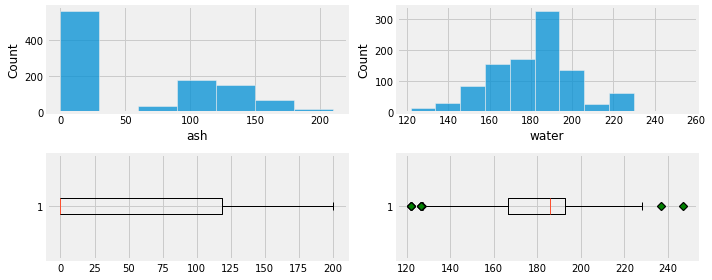

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

sns.histplot(data=data, x='ash', binwidth=30, ax=axes[0,0]);
sns.histplot(data=data, x='water', binwidth=12, ax=axes[0,1]);
axes[1,0].boxplot(data['ash'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['water'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

- The two distinct distributions of ash suggest different species of concrete. Concrete whose ash content falls between 0 and 30 $kg/m^3$ and those whose ash content is greater than 60 $kg/m^3$. In this latter range the ash content takes on the aspect of a normal distribution. 
- Water is fairly normal in its distribution with a large peak around 54 $kg/m^3$ with a couple outliers on both ends of the distribution

In [15]:
# percentage of mixtures that have 0 ash
missing_ash_perc = round(data[data.ash == 0].shape[0]/data.shape[0]*100)

print("{}% of the concrete mixtures had no ash added.".format(missing_ash_perc))

54% of the concrete mixtures had no ash added.


<b style="color:#2E86C1;font-size:15px;">Superplastic and Coarseagg</b>

In [16]:
data_report(data).loc[['superplastic','coarseagg']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
superplastic,1005.0,0.0,111,6.033234,5.919967,0.0,0.0,6.1,10.0,32.2,0.980604
coarseagg,1005.0,0.0,284,974.376816,77.579667,801.0,932.0,968.0,1031.0,1145.0,-0.065256


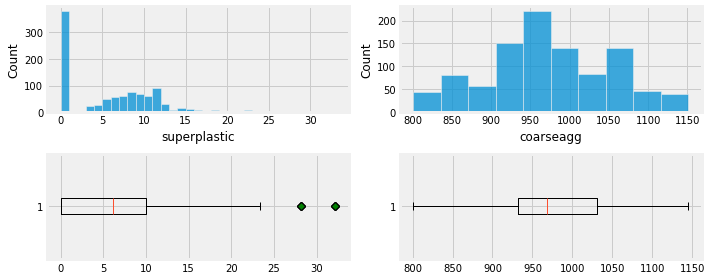

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

sns.histplot(data=data, x='superplastic',binwidth=1, ax=axes[0,0]);
sns.histplot(data=data, x='coarseagg', binwidth=35, ax=axes[0,1]);
axes[1,0].boxplot(data['superplastic'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['coarseagg'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

- Superplastic's distribution suggests two distinct types of concrete; concrete whose superplastic content falls between 0 and 1 $kg/m^3$, and concrete that contains more than 3 $kg/m^3$ of superplastic. In the latter case the superplastic content is fairly normal with a couple outliers. 
- Coarseagg exhibits the characteritics of a multimodal distribution with three pronounced peaks, the largest of which is centered around 972. The other two peaks are centered around 850 and 1060. 

In [18]:
# percentage of mixtures that have 0 superplastic
missing_superplastic_perc = round(data[data.superplastic== 0].shape[0]/data.shape[0]*100)

print("{}% of the concrete mixtures had no superplastic added.".format(missing_superplastic_perc))

38% of the concrete mixtures had no superplastic added.


<b style="color:#2E86C1;font-size:15px;">Fineagg and Age</b>

In [19]:
data_report(data).loc[['fineagg','age']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
fineagg,1005.0,0.0,302,772.688259,80.340435,594.0,724.3,780.0,822.2,992.6,-0.252353
age,1005.0,0.0,14,45.856716,63.734692,1.0,7.0,28.0,56.0,365.0,3.253974


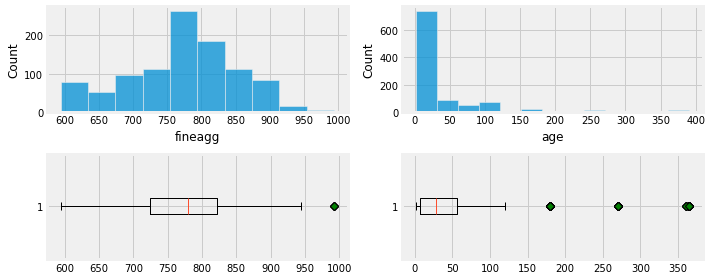

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=False)

sns.histplot(data=data, x='fineagg', binwidth=40, ax=axes[0,0]);
sns.histplot(data=data, x='age', binwidth=30, ax=axes[0,1]);
axes[1,0].boxplot(data['fineagg'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
axes[1,1].boxplot(data['age'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));
plt.tight_layout()

- Fineagg is close to normal with several outliers on the right.
- There is a high frequency of records where the age of the concrete is between 1 and 30 days. Several outliers exist with ages past 125 days.

<b style="color:#2E86C1;font-size:15px;">Strength</b>

In [21]:
data_report(data).loc[['strength']]

,count,% missing,cardinality,mean,std,min,25%,50%,75%,max,skew
strength,1005.0,0.0,845,35.250378,16.284815,2.33,23.52,33.8,44.87,82.6,0.395696


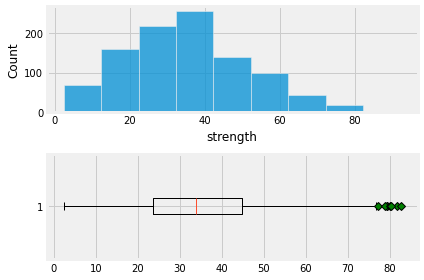

In [22]:
fig, axes = plt.subplots(2)

sns.histplot(data=data, x='strength', binwidth=10, ax=axes[0]);
axes[1].boxplot(data['strength'], vert=False, flierprops=dict(markerfacecolor='g', marker='D'));

plt.tight_layout()

- Concrete strength follows a normal distribution with a central tendency around 36 Mpa. There are a couple outliers leading to a small amount of right skewness.

#### 2.1 Bivariate Analysis
We begin our bivariate analysis by first looking at the correlations between the predictors and the response

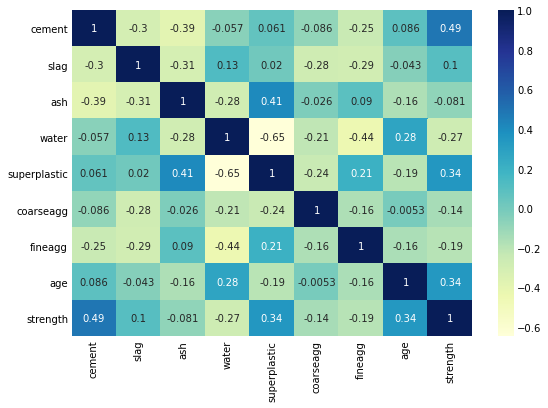

In [23]:
corr_df = data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_df,  annot=True, cmap="YlGnBu");

- Concrete strength has a strong linear relationship with the amount of cement. The more cement that is added the stronger the concrete. 
- Conrete also has a moderate linear relationship with both age and superplastic.
- Ash and slag have a moderate negative relationship (-0.31)
- Superplastic amd fineagg both have a strong negative relationship with water, -0.65 and -0.44, respectively.

Below is a series of scatter plots of each feature versus the compressive strength of the concrete.

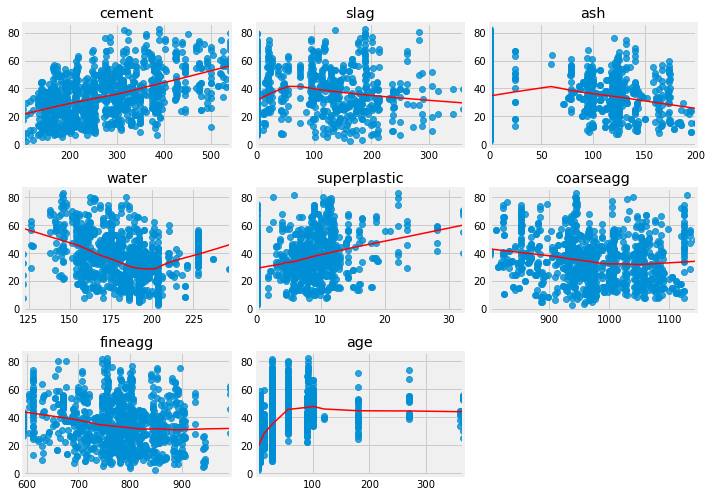

In [24]:
fig, axes = plt.subplots(3,3, figsize=(10,7))

for idx,feature in enumerate(data.columns[:-1]): 
    
    # create scatter plots
    ax=axes.flatten()[idx]
    sns.regplot(data=data, 
                x=feature, 
                y='strength', 
                ax=ax, 
                lowess=True, 
                line_kws={'color': 'red', 'linewidth':1.5}
               )
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(feature)

axes[2,2].set_axis_off()
plt.tight_layout()
plt.show()

- As noted earlier strength has a linear relationship with both cement and superplastic. 
- The plots also reveal a strong non-linear relationship with both water and age:
    - On average, the strongest concrete mixtures are allowed to cure at least 90 days.
    - On average the strongest mixtures have the lowest water concentration.
- Ash and superplastic have a large number of observations of a single amount namely zero, and the strength varies greatly for these values. 

<a id="3"></a>
### Step 3: Data Preprocessing and Feature Engineering
#### 3.1 Feature Engineering

We will add a host of new features to the data set using Sklearn's PolynomialFeatures class adding polynomial terms up to degree 3 e.g. cement, cement^2, cement x slag, etc. These features will be added later using sklearn's make_pipleline class.

#### 3.2 Create Training and Test Splits

In [26]:
# create input feature array
X = data.drop(columns=['strength'])

# create prediction labels
y = data['strength']

# 70:30 test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

<a id="4"></a>
### Step 4: Model Building and Evaluation

In this section we will train a collection of linear and non-linear models and evaluate their performance on the training set using 10-fold CV.

In [27]:
r2_avg = []
r2_std = []
rmse_avg = []
rmse_std = []

estimators = [Lasso(), ElasticNet(), Ridge(), PLSRegression(), BaggingRegressor(random_state=1), 
              RandomForestRegressor(random_state=1), AdaBoostRegressor(random_state=1), 
              GradientBoostingRegressor(random_state=1), KNeighborsRegressor()]

for estimator in estimators:
              
    pipe = make_pipeline(
        PolynomialFeatures(include_bias=False, degree=3), # adding polynomial features
        StandardScaler(), # scaling is necessary for the linear models and the KKN
        estimator)
    
    # calculate R^2 using 10-fold CV
    r2 = cross_val_score(estimator=pipe, 
                                X=X_train, 
                                y=y_train, 
                                cv=10, 
                                n_jobs=-1)
    
    # append R^2 average and std
    r2_avg.append(np.mean(r2))
    r2_std.append(np.std(r2))          
     
    # Calculate RMSE using 10-fold CV
    rmse = -1.0*cross_val_score(estimator=pipe, 
                           X=X_train, 
                           y=y_train, 
                           cv=10, 
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1)
              
    # append RMSE average and std
    rmse_avg.append(np.mean(rmse))
    rmse_std.append(np.std(rmse))

#### Model Evaluation Summary

In [28]:
model_labels = ['Lasso', 'Elastic Net', 'Ridge', 'PLSRegression', 'Bagged Trees',
'Random Forest', 'AdaBoost', 'GradientBoosting', 'KNN']

metrics = {'R squared':["%.3f +/- %.3f" % (r_2[0],r_2[1]) for r_2 in zip(r2_avg,r2_std)], 
           'RMSE':["%.3f +/- %.3f MPa" % (rmse[0],rmse[1]) for rmse in zip(rmse_avg,rmse_std)]} 

pd.DataFrame(metrics, index=model_labels)

,R squared,RMSE
Lasso,0.676 +/- 0.050,9.373 +/- 0.827 MPa
Elastic Net,0.690 +/- 0.051,9.165 +/- 0.808 MPa
Ridge,0.844 +/- 0.038,6.479 +/- 0.876 MPa
PLSRegression,0.618 +/- 0.065,10.152 +/- 0.776 MPa
Bagged Trees,0.885 +/- 0.025,5.574 +/- 0.734 MPa
Random Forest,0.897 +/- 0.024,5.276 +/- 0.744 MPa
AdaBoost,0.815 +/- 0.032,7.080 +/- 0.681 MPa
GradientBoosting,0.909 +/- 0.024,4.941 +/- 0.765 MPa
KNN,0.735 +/- 0.076,8.423 +/- 1.299 MPa


Out of the linear models ridge regression performed the best. Random forests and gradient boosting were the top performers. In the next section we will conduct some hyper-parameter tuning on these two models and see if we can squeeze out some extra performance.

<a id="5"></a>
### Step 5: Hyper Parameter Tuning using RandomSearchCV

#### Random Forests

Here are the hyper parameters that we will be searching over:
- **n_estimators:** The number of trees in the forest
- **max_features:** The number of features to consider when looking for the best split
- **max_depth:** The maximum depth of the tree
- **min_samples_split:** The minimum number of samples required to split an internal node
- **min_samples_leaf:** The minimum number of samples required to be at a leaf node

In [29]:
pipe_rf = make_pipeline(PolynomialFeatures(include_bias=False, degree=3), RandomForestRegressor(random_state=1))


# Create parameter grid
random_grid = {'randomforestregressor__n_estimators': [100, 200, 300, 400, 500],
               'randomforestregressor__max_features': ['auto', 'sqrt'],
               'randomforestregressor__max_depth': np.arange(10,110,10),
               'randomforestregressor__min_samples_split': [2, 5, 10, 20],
               'randomforestregressor__min_samples_leaf': [1, 2, 4, 8]}

# perform random grid search that maximizes R^2
randomCV_rf = RandomizedSearchCV(pipe_rf, 
                              param_distributions=random_grid, 
                              n_iter=20, # 20 samples
                              cv=10, # 10 folds
                              n_jobs=-1, 
                              verbose=2)

# fit the model
randomCV_rf.fit(X_train, y_train);

# display the best hyper parameters found
randomCV_rf.best_params_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.3min finished


{'randomforestregressor__n_estimators': 500,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_depth': 90}

In [57]:
print("R2 score before random search: 0.897")
print("R2 score after random search: {}".format(round(randomCV_rf.best_score_,3)))

R2 score before random search: 0.0.897
R2 score after random search: 0.9


In [58]:
rmse = np.sqrt(mean_squared_error(randomCV_rf.predict(X_train), y_train))

print("RMSE score before random search: 5.276")
print("RMSE score after random search: {}".format(round(rmse,3)))

RMSE score before random search: 5.276
RMSE score after random search: 2.115


Now that is quite an improvement in RMSE! 

#### Gradient Boosting

There are two types of hyper parameters for Gradient Boosting. The first type controls the behavior of the trees i.e. max_depth, max_features, etc. The second type of controls the boosting. These parameters are the learning rate and the number of trees in the boosting sequence. The learning rate scales the contribution of each tree and helps combat overfitting. However, there is a trade off between learning rate and number of trees; the lower the learning rate the more trees you will need in order for the model to generalize well on unseen data. This comes at a computational expense since adding more trees increases the computational runtime during training. For this reason we will tackle the hyper parameter tuning for Gradient Boosting in two stages:

1. Keep the default learning rate of 0.1 and then find the optimal number of trees using GridSearchCV.
2. Once an ideal number of trees are found then we will perform a random grid search of the tree hyper parameters.

In [32]:
pipe_gb = make_pipeline(PolynomialFeatures(include_bias=False, degree=3), GradientBoostingRegressor(random_state=1))

# perform grid search that maximizes R^2
gridcv_gb = GridSearchCV(pipe_gb, 
                         param_grid={'gradientboostingregressor__n_estimators': [100, 200, 300, 400, 500]}, 
                         cv=10, 
                         n_jobs=-1, 
                         verbose=2)

# refit the model
gridcv_gb.fit(X_train, y_train);

gridcv_gb.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


{'gradientboostingregressor__n_estimators': 500}

The grid search has identified that 400 trees is the best number of estimators given a learning rate of 0.1. We can now pass this number to the random grid search.

In [33]:
pipe_gb = make_pipeline(PolynomialFeatures(include_bias=False, degree=3), 
                        GradientBoostingRegressor(n_estimators=400, random_state=1)) # setting the number of trees to 500


# Create parameter grid
random_grid = {'gradientboostingregressor__max_features': ['auto', 'sqrt'],
               'gradientboostingregressor__max_depth': [3, 6, 9, 12],
               'gradientboostingregressor__min_samples_split': [2, 5, 10, 20],
               'gradientboostingregressor__min_samples_leaf': [1, 2, 4, 8]}

# perform random grid search that maximizes R^2
randomCV_gb = RandomizedSearchCV(pipe_gb, 
                              param_distributions=random_grid, 
                              n_iter=20, # 20 samples
                              cv=10, # 10 folds
                              n_jobs=-1, 
                              verbose=2)

# fit the model
randomCV_gb.fit(X_train, y_train);

randomCV_gb.best_params_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.2min finished


{'gradientboostingregressor__min_samples_split': 2,
 'gradientboostingregressor__min_samples_leaf': 8,
 'gradientboostingregressor__max_features': 'sqrt',
 'gradientboostingregressor__max_depth': 3}

In [59]:
print("Cross validated R2 score before random search: 0.909")
print("Cross validated R2 score after random search: {}".format(round(randomCV_gb.best_score_,3)))

Cross validated R2 score before random search: 0.909
Cross validated R2 score after random search: 0.925


In [60]:
rmse_gb = np.sqrt(mean_squared_error(randomCV_gb.predict(X_train), y_train))

print("Cross validated RMSE score before random search: 4.941")
print("Cross validated RMSE score after random search: {}".format(round(rmse,3)))

Cross validated RMSE score before random search: 4.941
Cross validated RMSE score after random search: 2.115


<a id="6"></a>
### Step 6: Model Performance on Unseen Data

In [ ]:
r2_train = []
rmse_train = []
r2_test = []
rmse_test = []
for model in [randomCV_rf, randomCV_gb]:
    
    r2_train.append(round(model.score(X_train, y_train),2))
    y_pred_train = model.predict(X_train)
    mse = mean_squared_error(y_pred_train,y_train)
    rmse_train.append(round(np.sqrt(mse),2)
                
    r2_test.append(round(model.score(X_test, y_test),2))
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_pred_test,y_test)
    rmse.append(round(np.sqrt(mse),2))


model_labels = ['Random Forest', 'Gradient Boosting']
metrics = {'R2':r2, 'RMSE':rmse}

pd.DataFrame(metrics, index=model_labels)

Gradient Boosting outperforms Random Forest by a decent margin in both R2 and RMSE. Below are plots of the observations, predictions, and residuals for both models.

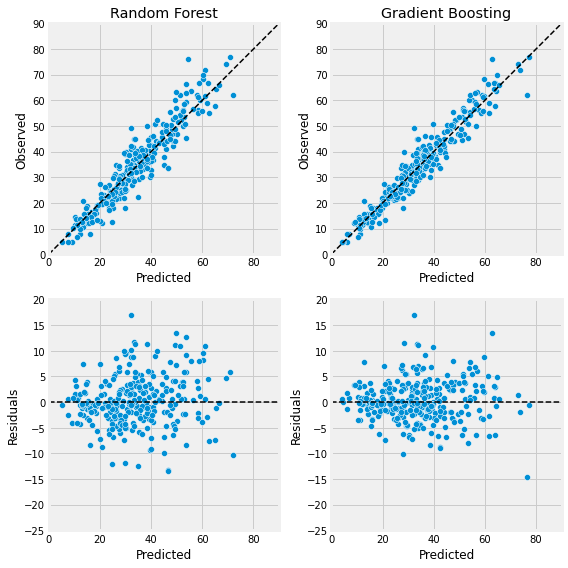

In [37]:
# predictions
y_pred_rf = randomCV_rf.predict(X_test)
y_pred_gb = randomCV_gb.predict(X_test)

# residuals
residuals_rf = y_test - y_pred_rf
residuals_gb = y_test - y_pred_gb

fig, axes = plt.subplots(2,2, figsize=(8,8))

axes = axes.flatten()

# plot predicted vs observed for random forest
sns.scatterplot(x=y_pred_rf, y=y_test, ax=axes[0])
axes[0].plot([0, 90], [0, 90], ls="--", c='k', linewidth=1.5)
axes[0].set_title("Random Forest")
axes[0].set_xlabel("Predicted");
axes[0].set_ylabel("Observed");
axes[0].set_xlim(0,90);
axes[0].set_ylim(0,90);

# plot predicted vs observed for gradient boosting
sns.scatterplot(x=y_pred_gb, y=y_test, ax=axes[1])
axes[1].plot([0, 90], [0, 90], ls="--", c='k', linewidth=1.5)
axes[1].set_title("Gradient Boosting")
axes[1].set_xlabel("Predicted");
axes[1].set_ylabel("Observed");
axes[1].set_xlim(0,90);
axes[1].set_ylim(0,90);

# plot residuals for random forest
sns.scatterplot(x=y_pred_rf, y=residuals_rf, ax=axes[2]);
axes[2].axhline(y=0, color='k', linestyle='--', linewidth=1.5);
axes[2].set_xlabel("Predicted");
axes[2].set_ylabel("Residuals")
axes[2].set_xlim(0,90);
axes[2].set_ylim(-25,20);

# plot residuals for gradient boosting
sns.scatterplot(x=y_pred_gb, y=residuals_gb, ax=axes[3]);
axes[3].axhline(y=0, color='k', linestyle='--', linewidth=1.5);
axes[3].set_xlabel("Predicted");
axes[3].set_ylabel("Residuals")
axes[3].set_xlim(0,90);
axes[3].set_ylim(-25,20);

plt.tight_layout()

There is good concordance with the observed and predicted values, and there is no discernable pattern in the residuals which suggests that both models are generalizing well.

<a id="7"></a>
### Step 7: Optimizing Compressive Strength using Particle Swarm Optimization 

In this section, using our tuned gradient boosting model, we attempt to find a concrete mixture that will maximize compressive strength. Once found, we could then send this ideal mixture to the industrial engineers for testing and verification. 

This section is divided into several parts. First, we provide a mathematical definition of optimization followed by a brief overview of Particale Swarm Optimization (PSO), and finally the application of PSO for finding an ideal concrete mixture that maximizes compressive strength.

#### 7.1 Mathematical Optimization Formalism

In applied mathematics optimization refers to the procedures used to find a “best” solution - amongst a set of candidate solutions - to a given problem. In general there are three
aspects that are common to all optimization problems: an objective function, a search space,
and constraints. The objective function is the quantity in which one wishes to optimize. The
search space S is the set containing the candidate solutions which are used to evaluate the
objective function. Constraints limit the search to candidate solutions contained within some
feasible space F ⊆ S. Constraints are often found in real world optimization problems where
time, money, and resources are limited. 

So in this context we have the following:
1. The **objective funtion** is the gradient boosting model. 
2. The **search space** is the concrete mixture ingredients. This is a 9-dimensional search space that includes all of the input features from cement to age and the engineered feature cement to water ratio. 
3. The **constraints** were defined using the original minimum and maximum feature values in the data set.

#### 7.2 Overview of Particle Swarm Optimization

Particle Swarm Optimization (PSO) is a population based stochastic search optimization algorithm. The population or swarm consists of a number of particles N that explore a ndimensional search space where the location of each particle within the space is adjusted based on its own experience and that of its neighbors.

Let $x_{i}(t), v_{i}(t) ∈ R^{n}$ for i = 1, . . . , n be the position and velocity of the *ith* particle,respectively. Here $t$ denotes a discrete time step. The position of the ith particle is adjusted by adding the velocity to the current position, that is <br><br>
\begin{equation*}
x_{i}(t + 1) = x_{i}(t) + v_{i}(t + 1)
\label{eq:pos} \tag{1}
\end{equation*}
<br>
In practice, the initial positions are confined within some boundary i.e. $x_{min} ≤ x_{i}(0) ≤ x_{max}$.
There are two main variations of the PSO algorithm, namely the global best PSO and the
local best PSO, which differ only in the size of their neighborhoods. The social interconnectivity of the swarm is often referred to as the neighborhood topology or social network structure. 

##### 7.2.1 Global Best PSO

In the global best PSO, or simply gbest PSO, the neighborhood of each particle is the entire swarm. Every particle experiences an attraction towards its personal best value pBest and the best position encountered by any particle which we call the global best or simply gBest. Let the personal best position of particle *i*, in a n-dimensional search space be given by 

\begin{equation*}
\mathbf{p}_{i}=[p_{i1},p_{i2},\ldots,p_{in}],
\end{equation*}

and let the global best position be given by

\begin{equation*}
\mathbf{g}=[g_{1},g_{2},\ldots,g_{n}].
\end{equation*}

After each iteration *t* the velocity of the *ith* particle is updated using the following equation:
<br><br>
\begin{equation*}
v_{ij}(t+1)=\omega v_{ij}(t)+r_{1}c_{1}(p_{ij}-x_{ij}(t-1))+r_{2}c_{2}(g_{j}-x_{ij}(t-1)),
\label{eq:vel_update} \tag{2}
\end{equation*}

<br><br>
where *r<sub>1</sub>* and *r<sub>2</sub>* are random numbers uniformly distributed between 0 and 1, *p<sub>ij</sub>* and *g<sub>j</sub>* are the *jth* component of pBest and gBest, respectively, *c<sub>1</sub>* (cognitive parameter) and *c<sub>2</sub>* (social parameter) are weights that scale the attraction towards *p<sub>ij</sub>* and *g<sub>j</sub>*, while *ω* is referred to as the inertial parameter. The particle positions are updated using (1) then each particle
evaluates the objective function *f* using its current position i.e. $f_{i} = f(x_{i}(t + 1))$ and the
vectors *p<sub>i</sub>* and *g* are updated in the following way:

\begin{equation*}
\label{eq:p_update} \tag{3}
\mathbf{p}_{i}(t+1)=\left\{ \begin{array}{lc}
\mathbf{p}_{i}(t) & \mbox{if}\: f(\mathbf{x}_{i}(t+1)\geq f(\mathbf{p}_{i}(t))\\
\mathbf{x}_{i}(t+1) & \mbox{if}\: f(\mathbf{x}_{i}(t+1)<f(\mathbf{p}_{i}(t))
\end{array}\right.
\end{equation*}

\begin{equation*}
\mathbf{g}=\mathbf{p}_{i}(t+1)\mbox{ s.t. }f(\mathbf{p}_{i}(t+1))\leq f(\mathbf{p}_{j}(t+1))\mbox{ for }j=1,\ldots,N.
\label{eq:g_update} \tag{4}
\end{equation*}

#### 7.3 Optimizing Concrete Strength using PSO

The implementation of PSO will be done using the PySwarms research toolkit which is "intended for swarm intelligence researchers, practitioners, and students who prefer a high-level declarative interface for implementing PSO in their problems. PySwarms enables basic optimization with PSO and interaction with swarm optimization". You can read more about the PySwarms package <a href="https://pyswarms.readthedocs.io/en/latest/index.html">here</a>. 

Out of the box, PySwarms PSO tries to minimize an objective function, but for our purposes we need to maximize the objective function instead. Because of this we a simple user defined function which multiplies the output of our gradient boosting model by -1.

In [45]:
# create user-defined function 
def gradient_boosting(x, verbose):
    return -1.0*randomCV_gb.predict(x)

# search space dimensions
ndim = X.shape[1]

# set constraints using the min and max values of the input features
lower_bounds = np.array(X.min())
upper_bounds = np.array(X.max())
bounds = (lower_bounds, upper_bounds)

# set values for the cognitive, social, and inertial parameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

Due to PSO stochastic nature you are not guaranteed to get the same results every time. Thus we will run 3 trials and record the results. 

In [43]:
results = np.empty(shape=(3,9))
trials = np.arange(1,4)

for trial in trials:
    
    # initialize global best PSO optimizer
    optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=ndim, options=options, bounds=bounds)

    # run the optimizer
    cost, mix = optimizer.optimize(gradient_boosting, iters=1000, verbose=False)
    
    # change the sign of the cost
    strength = -1.0*cost
    
    results[trial-1,:] = np.append(mix,strength)

2020-10-30 14:11:59,476 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|1000/1000, best_cost=-96.3
2020-10-30 14:12:01,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -96.25982984052592, best pos: [527.1555618  210.08635811 111.55014461 146.75603154  10.28424711
 920.38786337 781.5218413  157.03596601]
2020-10-30 14:12:01,596 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|1000/1000, best_cost=-97.8
2020-10-30 14:12:03,640 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -97.75735009962622, best pos: [ 528.60584531  319.64481089   38.96459496  148.89876211   11.35850406
 1003.99455013  731.57212618  290.49816093]
2020-10-30 14:12:03,646 - pyswar

#### 7.3.1 Results

In [54]:
results_df = pd.DataFrame(data=results, index=["mixture 1", "mixture 2", "mixture 3"], columns=data.columns).T
results_df

,mixture 1,mixture 2,mixture 3
cement,527.155562,528.605845,526.465115
slag,210.086358,319.644811,308.415133
ash,111.550145,38.964595,141.926811
water,146.756032,148.898762,144.625480
superplastic,10.284247,11.358504,10.293439
coarseagg,920.387863,1003.994550,959.730346
fineagg,781.521841,731.572126,752.680495
age,157.035966,290.498161,348.149416
strength,96.259830,97.757350,100.648226


Above are the maximum compressive strengths of three different mixtures found during the search. Note all three mixtures tend to agree on the contents of cement, water, and superplastic. It's also worth noting that the ideal curing times are all great than 90 days which agrees with the findings we found earlier in the exploratory data analysis. Furthermore, the water content is also in the lower range of values which is what we observed for the strongest mixtures. And last but not least, are the predicted compressive strengths of 96.26, 97.76, a 100.65. These values are larger than the largest observed compressive strength in the data set. 

In [56]:
results_df['max values'] = data.max()
results_df

,mixture 1,mixture 2,mixture 3,max values
cement,527.155562,528.605845,526.465115,540.0
slag,210.086358,319.644811,308.415133,359.4
ash,111.550145,38.964595,141.926811,200.1
water,146.756032,148.898762,144.625480,247.0
superplastic,10.284247,11.358504,10.293439,32.2
coarseagg,920.387863,1003.994550,959.730346,1145.0
fineagg,781.521841,731.572126,752.680495,992.6
age,157.035966,290.498161,348.149416,365.0
strength,96.259830,97.757350,100.648226,82.6


Comparing the mixture content themselves to maximum values of their respective features in the data set we that only cement is near the maximum observed value. This should not come as a surprise due to the linear relationship between cement and compressive strength. At this stage we could pass on the mixtures to the industrial engineers for scientific testing. 